In [1]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import pandas as pd

In [2]:
def parser(x):
    return datetime.strptime('200' + x, '%Y-%m')

In [3]:
series = read_csv('sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,
                  date_parser=parser)

Month
2001-01-01    266.0
2001-02-01    145.9
2001-03-01    183.1
2001-04-01    119.3
2001-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


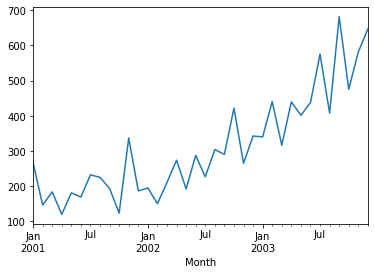

In [4]:
print(series.head())
# line plot
series.plot()
pyplot.show()

In [9]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from math import sqrt
import matplotlib

In [10]:
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

In [11]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [12]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [13]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [14]:
# fit an LSTM network to training data
def fit_rnn(train, n_batch, nb_epoch, n_neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(SimpleRNN(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model


In [15]:
# run a repeated experiment
def run_rnn(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:, :]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        train_trimmed = train_scaled[2:, :]
        rnn_model = fit_rnn(train_trimmed, n_batch, n_epochs, n_neurons)
        # forecast test dataset
        test_reshaped = test_scaled[:, 0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = rnn_model.predict(test_reshaped, batch_size=n_batch)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i, 0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r + 1, rmse))
        error_scores.append(rmse)
    return error_scores

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
1) Test RMSE: 91.962
2) Test RMSE: 116.152
3) Test RMSE: 96.159
4) Test RMSE: 80.606
5) Test RMSE: 84.426
6) Test RMSE: 96.020
7) Test RMSE: 82.491
8) Test RMSE: 95.120
9) Test RMSE: 84.431
10) Test RMSE: 92.610
11) Test RMSE: 86.035
12) Test RMSE: 82.013
13) Test RMSE: 101.126
14) Test RMSE: 94.834
15) Test RMSE: 86.481
16) Test RMSE: 87.481
17) Test RMSE: 96.669
18) Test RMSE: 90.145
19) Test RMSE: 85.360
20) Test RMSE: 84.772
21) Test RMSE: 70.295
22) Test RMSE: 90.120
23) Test RMSE: 90.566
24) Test RMSE: 76.748
25) Test RMSE: 123.326
26) Test RMSE: 132.128
27) Test RMSE: 86.131
28) Test RMSE: 82.770
29) Test RMSE: 85.134
30) Test RMSE: 83.138
          results
count   30.000000
mean    91.174968
std     12.980988
min     70.294742
25%     84.427060
50%     86.981189
75%     95.048407
max    132.127738


/Users/rdua/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


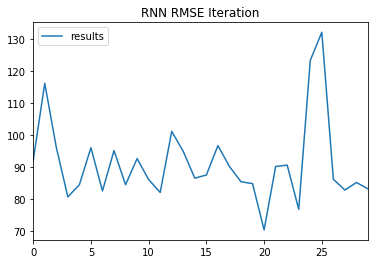

In [17]:
# load dataset
series = read_csv('sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,
                      date_parser=parser)
# configure the experiment
n_lag = 1
n_repeats = 30
n_epochs = 1000
n_batch = 4
n_neurons = 3
# run the experiment
results = DataFrame()
results['results'] = run_rnn(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons)

results.plot(title="RNN RMSE Iteration")

pyplot.show()
# summarize results
print(results.describe())
# save boxplot

pyplot.savefig('plot_rnn_rmse.png')